<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>LGBMClassifier</a></span></li><li><span><a href="#Полносвязная-нейронная-сеть" data-toc-modified-id="Полносвязная-нейронная-сеть-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Полносвязная нейронная сеть</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Прогнозирование оттока клиентов телекоммуникационной компании

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Исследование пройдет в 6 этапов:
1. Обзор данных.
2. Предобработка данных.
3. Исследовательский анализ данных.
4. Обучение моделей.
5. Тестирование лучшей модели.
6. Выводы.

## Обзор данных

Импортируем библиотеки:

In [1]:
!pip install -q phik 

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from lightgbm import LGBMClassifier
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import notebook
import phik
from phik.report import plot_correlation_matrix

pd.set_option('display.max_columns', None)

In [3]:
SEED = 42
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cpu


Подключение к удаленной базе данных:

In [4]:
db_config = {
'user': 'praktikum_student',
'pwd': 'Sdf4$2;d-d30pp',
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,
'db': 'data-science-final'
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string) 

Выведем на экран первые 5 строк каждой таблицы:

In [5]:
tables = ['contract', 'personal', 'internet', 'phone']
for table in tables:
    query = f'''
            SELECT *
            FROM telecom.{table}
            LIMIT 5;
         '''
    display(table, pd.read_sql_query(query, con=engine))

'contract'

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


'personal'

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


'internet'

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


'phone'

,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes


Посмотрим на количество записей в таблицах:

In [6]:
tables = ['contract', 'personal', 'internet', 'phone']
for table in tables:
    query = f'''
                SELECT COUNT(*)
                FROM telecom.{table};
             ''' 
    display(table, pd.read_sql_query(query, con=engine))

'contract'

,count
0,7043


'personal'

,count
0,7043


'internet'

,count
0,5518


'phone'

,count
0,6362


**Выводы:**

В нашем распоряжении 4 таблицы, соответствующие условию задачи: 
- `contract` — содержит информацию о договоре, 7043 записи;
- `personal` — содержит персональные данные клиента, 7043 записи;
- `internet` — содержит информацию об интернет-услугах, 5518 записей (в т.ч. одна строка с заголовками);
- `phone` — содержит информацию об услугах телефонии, 6362 записей (в т.ч. одна строка с заголовками).

Все таблицы содержат информацию, которая может быть использовала при обучении моделей. Информация о договорах актуальна на 1 февраля 2020 года. Также у всех перечисленных таблиц есть общий ключ `customerID`.

Согласно документации в таблицах имеются следующие колонки с данными:
- **contract:**
  - `customerID` - ID пользователя;
  - `BeginDate` — дата начала действия договора;
  - `EndDate` - дата окончания действия договора;
  - `Type` - тип оплаты (раз в год или помесячно);
  - `PaperlessBilling` - безбумажный расчётный лист;
  - `PaymentMethod` - тип платежа;
  - `MonthlyCharges` - расход за месяц;
  - `TotalCharges` - общие расходы.
- **personal:**
  - `customerID` - ID пользователя;
  - `gender` - пол;
  - `SeniorCitizen` - является ли абонент пенсионером;
  - `Partner` - есть ли у абонента супруг/супруга;
  - `Dependents` - есть ли у абонента дети.
- **internet:**
  - `customerID` - ID пользователя;
  - `InternetService` - тип подключения;
  - `OnlineSecurity` - блокировка небезопасных сайтов;
  - `OnlineBackup` - облачное хранилище файлов для резервного копирования данных;
  - `DeviceProtection` - антивирус;
  - `TechSupport` - выделенная линия технической поддержки;
  - `StreamingTV` - стриминговое телевидение;
  - `StreamingMovies` - каталог фильмов.
- **phone:**
  - `customerID` - ID пользователя;
  - `MultipleLines` - подключение телефонного аппарата к нескольким линиям одновременно.

## Предобработка данных

Объединим таблицы и выгрузим данные:

In [7]:
query = '''
           SELECT c."customerID",
                  "BeginDate",
                  "EndDate",
                  "Type",
                  "PaperlessBilling",
                  "PaymentMethod",
                  "MonthlyCharges",
                  "TotalCharges",
                  gender,
                  "SeniorCitizen",
                  "Partner",
                  "Dependents",
                  i.c2 AS "InternetService",
                  c3 AS "OnlineSecurity",
                  c4 AS "OnlineBackup",
                  c5 AS "DeviceProtection",
                  c6 AS "TechSupport",
                  c7 AS "StreamingTV",
                  c8 AS "StreamingMovies",
                  ph.c2 AS "MultipleLines"
           FROM telecom.contract as c
           LEFT JOIN telecom.personal AS p
                  ON c."customerID" = p."customerID"
           LEFT JOIN telecom.internet AS i
                  ON c."customerID" = i.c1
           LEFT JOIN telecom.phone as ph
                  ON c."customerID" = ph.c1;
        '''

df = pd.read_sql_query(query,
                        con=engine,
                        index_col='customerID',
                        parse_dates=['BeginDate', 'EndDate']
                        )

def total_view(df: pd.DataFrame, n_rows=5, seed=None):
    '''Возвращает первые, случайные и последние строки таблицы (по умолчанию по 5 строк)'''
    return display(pd.concat([
                              df.head(n_rows),
                              df.sample(n_rows, random_state=seed),
                              df.tail(n_rows)
                             ]))

total_view(df)
display(df.describe().T)
df.info()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,None
3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,None,None,None,None,None,None,None,No
3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
1530-ZTDOZ,2019-03-04,NaT,Month-to-month,No,Bank transfer (automatic),40.65,2070.75,Female,0,Yes,No,DSL,Yes,No,No,No,Yes,No,None
6894-LFHLY,2019-01-16,2019-11-01,Month-to-month,Yes,Electronic check,75.75,75.75,Male,1,No,No,Fiber optic,No,No,No,No,No,No,Yes
4488-PSYCG,2018-11-25,2019-10-01,Month-to-month,No,Bank transfer (automatic),20.25,327.45,Male,0,No,No,None,None,None,None,None,None,None,No
8547-NSBBO,2019-05-27,NaT,Month-to-month,Yes,Mailed check,96.75,3403.40,Male,0,No,No,Fiber optic,Yes,Yes,Yes,Yes,No,No,Yes


,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.00,0.000,0.0000,1.00


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 4472-LVYGI to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           1869 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   5517 non-null   object        
 12  OnlineSecurity    5517 non-null   object        
 13  OnlineBackup      5517 non-null   object        
 14  DeviceProtecti

In [8]:
df.duplicated().sum()

0

- типы данных в колонках соответствуют содержащимся в них типам данных;
- если сопоставить количество прошедших месяцев, размер расходов за месяц и общие расходы (`TotalCharges`), то видно, что данные в колонке `TotalCharges` не соответствуют действительности;
- в `EndDate` пропущенные значения соответствуют контрактам, действующим на дату выгрузки, на основе этой информации можно выделить целевую переменную;
- пропуски в других колонках объясняются возможностью использования услуг на выбор абонента;
- названия колонок записаны в стиле CamelCase;
- дубликаты отсутствуют.

Приведем названия колонок к змеиному стилю:

In [9]:
df.columns = ['begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method', 'monthly_charges',
              'total_charges', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service',
              'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
              'streaming_movies', 'multiple_lines']

Посмотрим на строки с пропусками в `total_charges`:

In [10]:
df[df['total_charges'].isna()]

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,None
3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,None,None,None,None,None,None,None,No
5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,Yes,None,None,None,None,None,None,None,Yes
1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,None
3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,Yes,None,None,None,None,None,None,None,Yes
2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,Yes,None,None,None,None,None,None,None,No
2775-SEFEE,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),61.90,NaN,Male,0,No,Yes,DSL,Yes,Yes,No,Yes,No,No,Yes
7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,Yes,None,None,None,None,None,None,None,No


Все пропуски в `total_charges` соответствуют контрактам, заключенным в дату выгрузки данных. Можно предположить, что по ним еще не поступала оплата, заполним такие пропуски нулем:

In [11]:
df['total_charges'] = df['total_charges'].fillna(0)

Выделим целевую пременную на основе поля `end_date`: yаличие даты будет положительным классом, а ее отсутствие отрицательным. Посмотрим на баланс классов:

In [12]:
df.loc[df['end_date'].isna(), 'target'] = 0
df.loc[~(df['end_date'].isna()), 'target'] = 1
df['target'].value_counts(normalize=True)

0.0    0.73463
1.0    0.26537
Name: target, dtype: float64

Классы не сбалансированы. Оставшиеся клиенты составляют 73.3% выборки, а ушедшие 27.7%.

Заполним пропущенные значения в `end_date` датой выгрузки данных:

In [13]:
df['end_date'] = df['end_date'].fillna(np.datetime64('2020-02-01'))

Добавим признак `services`, показывающий вид используемых услуг - интернет, телефон или обе.

In [14]:
df.loc[(df['internet_service'].isna()) \
   & (~df['multiple_lines'].isna()), 'services'] = 'phone'
df.loc[(~df['internet_service'].isna()) \
   & (df['multiple_lines'].isna()), 'services'] = 'internet'
df.loc[(~df['internet_service'].isna()) \
   & (~df['multiple_lines'].isna()), 'services'] = 'both'

Посмотрим на уникальные значения в колонках с категориальными данными:

In [15]:
cat_cols = ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner',
            'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection',
            'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines', 'services']
for column in cat_cols:
    print(f'{column}:',
          df[column].value_counts(dropna=False),
          sep='\n',
          end='\n\n')

type:
Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

paperless_billing:
Yes    4171
No     2872
Name: paperless_billing, dtype: int64

payment_method:
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64

gender:
Male      3555
Female    3488
Name: gender, dtype: int64

senior_citizen:
0    5901
1    1142
Name: senior_citizen, dtype: int64

partner:
No     3641
Yes    3402
Name: partner, dtype: int64

dependents:
No     4933
Yes    2110
Name: dependents, dtype: int64

internet_service:
Fiber optic    3096
DSL            2421
NaN            1526
Name: internet_service, dtype: int64

online_security:
No     3498
Yes    2019
NaN    1526
Name: online_security, dtype: int64

online_backup:
No     3088
Yes    2429
NaN    1526
Name: online_backup, dtype: int64

device_protection:
No     3095
Yes    2422
NaN    1526
Name: device_p

Неявные дубликаты отсутствуют, все пропуски заполним значением 'No' (кроме `multiple_lines` - 'No' в ней означает подключение только к одной линии), так как если данные отсутствовали в таблицах `internet` и `phone`, значит клиент не подключал данные услуги:

In [16]:
df['multiple_lines'] = df['multiple_lines'].fillna('No phone')
df = df.fillna('No')

**Выводы:**
- таблицы объединены по ключу `customerID` и выгружены в датафрейм;
- пропуски в колонке `TotalCharge` заполнены нулем;
- на основе данных из `end_date` сформирована целевая переменная;
- пропущенные даты в `end_date` заполнены датой выгрузки данных ('2020-02-01'); 
- образовавшиеся после объединения таблиц пропуски в остальных колонках заполнены значением 'No';
- добавлени признак `services` показывающий вид используемых услуг - интернет, телефон или обе.

## Исследовательский анализ данных

Сравним распределения величин ежемесячных платежей и общих расходов всех действующих клиентов и тех, кто ушел:

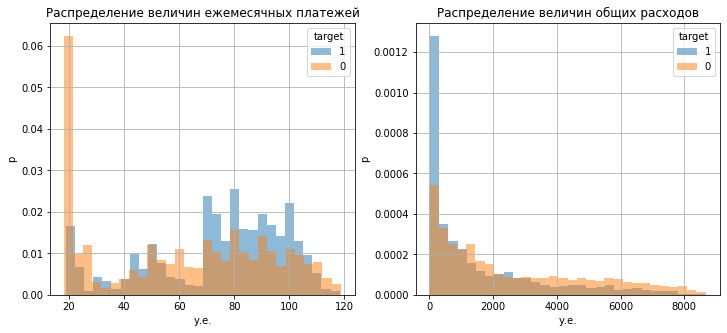

In [17]:
plt.figure(figsize=(12,5))
cnt = 1
for column in ['monthly_charges', 'total_charges']:
    plt.subplot(1, 2, cnt)
    plt.xlabel('у.е.')
    plt.ylabel('p')
    df.loc[df['target'] == 1, column].hist(bins=30, density=True, alpha=0.5)
    df.loc[df['target'] == 0, column].hist(bins=30, density=True, alpha=0.5)
    plt.legend(['1', '0'], title='target')
    if cnt == 1:
        plt.title('Распределение величин ежемесячных платежей')
    else:
        plt.title('Распределение величин общих расходов')
    cnt += 1

In [18]:
stat = pd.concat(
    [round(df.loc[df['target'] == 0, 'monthly_charges'].describe(), 2),
     round(df.loc[df['target'] == 1, 'monthly_charges'].describe(), 2),
     round(df.loc[df['target'] == 0, 'total_charges'].describe(), 2),
     round(df.loc[df['target'] == 1, 'total_charges'].describe(), 2)],
    axis=1)
stat.columns = ['loyal_clients_month', 'ex_clients_month', 'loyal_clients_total', 'ex_clients_total']
display(stat)

,loyal_clients_month,ex_clients_month,loyal_clients_total,ex_clients_total
count,5174.00,1869.00,5174.00,1869.00
mean,61.27,74.44,2549.91,1531.80
std,31.09,24.67,2329.95,1890.82
min,18.25,18.85,0.00,18.85
25%,25.10,56.15,572.90,134.50
50%,64.43,79.65,1679.52,703.55
75%,88.40,94.20,4262.85,2331.30
max,118.75,118.35,8672.45,8684.80


Ежемесячные расходы клиентов, которые ушли, в среднем выше (74.44 у.е.), чем расходы оставшихся (61.27 у.е.). На графике видно, что среди оставшихся клиентов большая доля клиентов в месяц в среднем платит 20 у.е., также разница в размере платежа заметна начиная с первого квартиля - 25% оставшихся клиентов платит менее 25.1 у.е., а у 25% бывших клиентов платеж составлял менее 56.15 у.е. Общие расходы у оставшихся клиентов в среднем больше (2550 у.е.), чем у ушедших (1531 у.е.).

Сравним доли пользователей разных видов услуг по каждой группе клиентов:

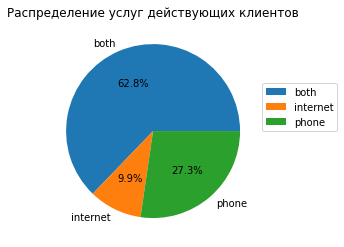

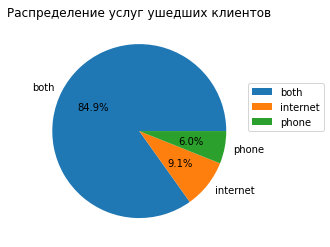

In [19]:
df.loc[df['target'] == 0] \
  .groupby('services') \
  .agg({'monthly_charges': 'count'}) \
  .plot(kind='pie', subplots=True, autopct='%1.1f%%', figsize=(4,4))
plt.title('Распределение услуг действующих клиентов')
plt.axis('off')
plt.legend(loc=(1,0.5))

df.loc[df['target'] == 1] \
  .groupby('services') \
  .agg({'monthly_charges': 'count'}) \
  .plot(kind='pie', subplots=True, autopct='%1.1f%%', figsize=(4,4))
plt.title('Распределение услуг ушедших клиентов')
plt.axis('off')
plt.legend(loc=(1,0.5))
plt.show()

Среди ушедших клиентов доля использовавших обе услуги больше (84.9%), чем среди оставшихся (62.8%). Среди оставшихся клиентов доля использовавших только телефонную связь выше (27.3%), чем среди ушедших (6%).

Сравним поведение разных групп клиентов по остальным категориальным признакам:

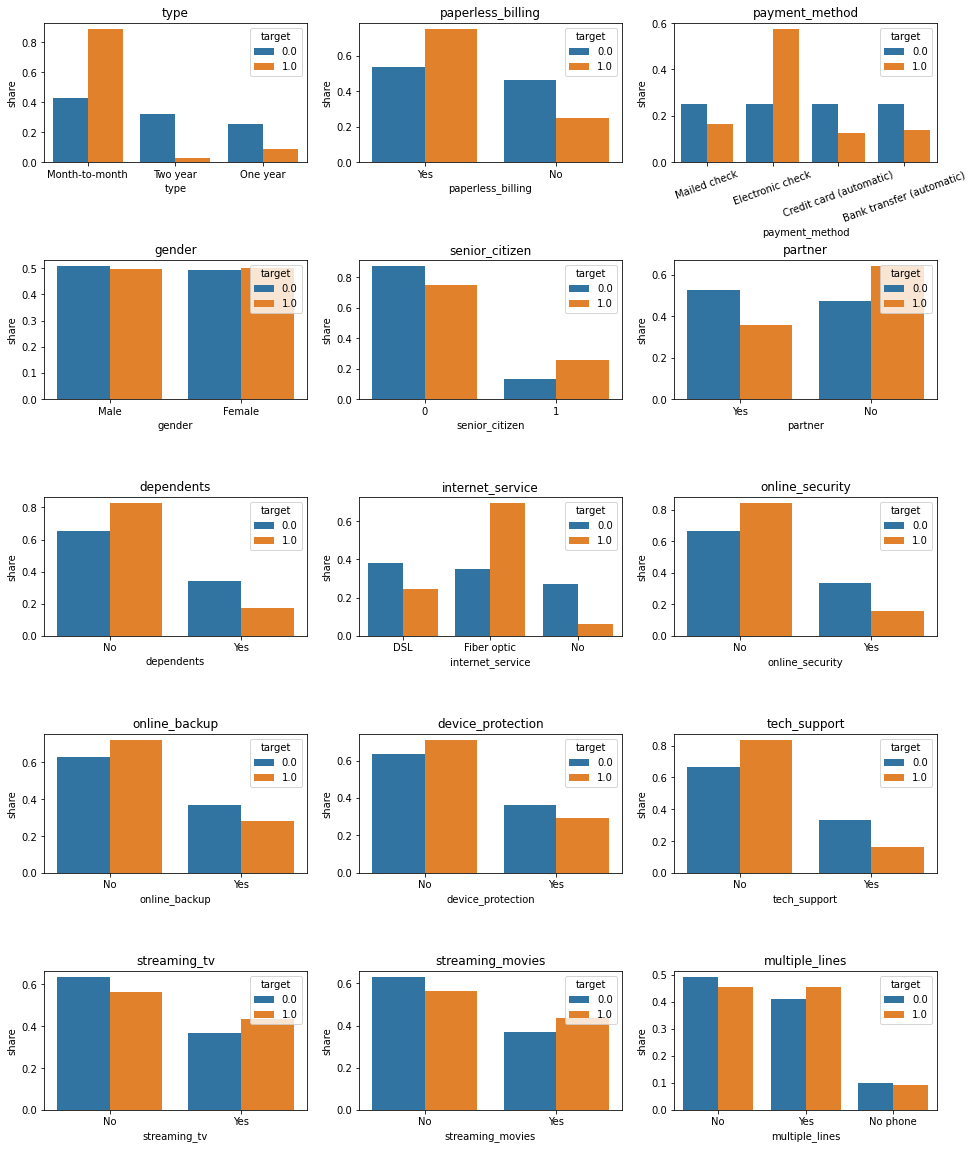

In [20]:
cat_cols = ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner',
            'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection',
            'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']
cnt = 1
plt.figure(figsize=(16, 20))
plt.subplots_adjust(hspace=0.7)
for column in cat_cols:
    plt.subplot(5, 3, cnt)
    tmp = df.groupby('target')[column].value_counts(normalize=True).rename('share').reset_index()
    sns.barplot(data=tmp, y='share', x=column, hue='target')
    if cnt == 3:
        plt.xticks(rotation = 20)
    plt.title(column)
    cnt += 1

- большинство ушедших клиентов платили за услуги помесячно, контракты на год-два заключали в основном те, кто остался;
- ушедшие клиенты предпочитали безбумажные расчетный лист, осташиеся в своих предпочтениях разделились примерно поровну;
- из типов платежа больше половины ушедших клиентов выбирали электонный счет;
- пол клиента не влияет на отток;
- доля пенсионеров среди ушедших клиентов больше, чем доля пенсионеров среди оставшихся;
- среди ушедших клиентов доля холостых больше, а оставшиеся делятся на замужних/женатых и холостых почти поровну;
- клиенты с детьми чаще остаются в компании, чем бездетные;
- ушедшие клиенты использовали подключение преимущественно через оптоволоконный кабель;
- по услугам блокировки небезопасных сайтов (online_security), антивируса (device_protection), выделенной линии технической поддержки (tech_support) и облачного хранилища файлов для резервного копирования данных (online_backup) ситуация одинаковая: ушедшие клиенты чаще их не использовали, а доля тех из них, кто пользовалася перечисленными услугами, ниже, чем доля оставшихся клиентов, использовавших эти услуги.
- услугами стримингового телевидения (streaming_tv) и каталога фильмов (streaming_movies) среди ушедших клиентов пользовалось чуть меньше половины. Доля оставшихся клиентов, пользующаяся перечисленными услугами меньше доли ушедших;
- среди ушедших клиентов, доля пользуюущихся подключением телефонного аппарата к нескольким линиям одновременно составляет примерно столько же, сколько не пользующихся. Доля оставшихся клиентов пользующаяся данной услугой меньше доли не пользуюущихся.

Посмотрим, есть ли закономерности в датах оттока клиентов:

In [21]:
df.loc[df['target'] == 1] \
  .groupby('end_date') \
  .agg({'begin_date': 'count'}) \
  .rename(columns={'begin_date': 'count'})

,count
end_date,
2019-10-01,458
2019-11-01,485
2019-12-01,466
2020-01-01,460


Все ушедшие клиенты покинули компанию в период с 1 октября 2019 года по 1 января 2020 года. Возможно в этот период они нашли более выгодное предложение у конкурентов.

Посмотрим как распределено количество поступления новых клиентов среди оставшихся и ушедших:

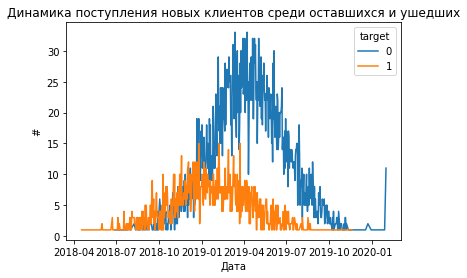

In [22]:
plt.plot(df.loc[df['target'] == 0]
  .groupby('begin_date')
  .agg({'monthly_charges': 'count'}))
plt.plot(df.loc[df['target'] == 1]
  .groupby('begin_date')
  .agg({'monthly_charges': 'count'}))
plt.title('Динамика поступления новых клиентов среди оставшихся и ушедших')
plt.xlabel('Дата')
plt.ylabel('#')
plt.legend(['0', '1'], title='target')
plt.show()

Большинство клиентов, покинувших компанию, пришли в период с октября 2018 по май 2019. Клиенты, которые остались в компании, преимущественно пришли в период с января по июль 2019 года. С июня 2019 года налюдается снижение динамики поступления новых клиентов, с сентября 2019 года перестали приходить клиенты из подгруппы покинувших компанию.

Проанализируем корреляцию между признаками с помощью Phik-корреляции:

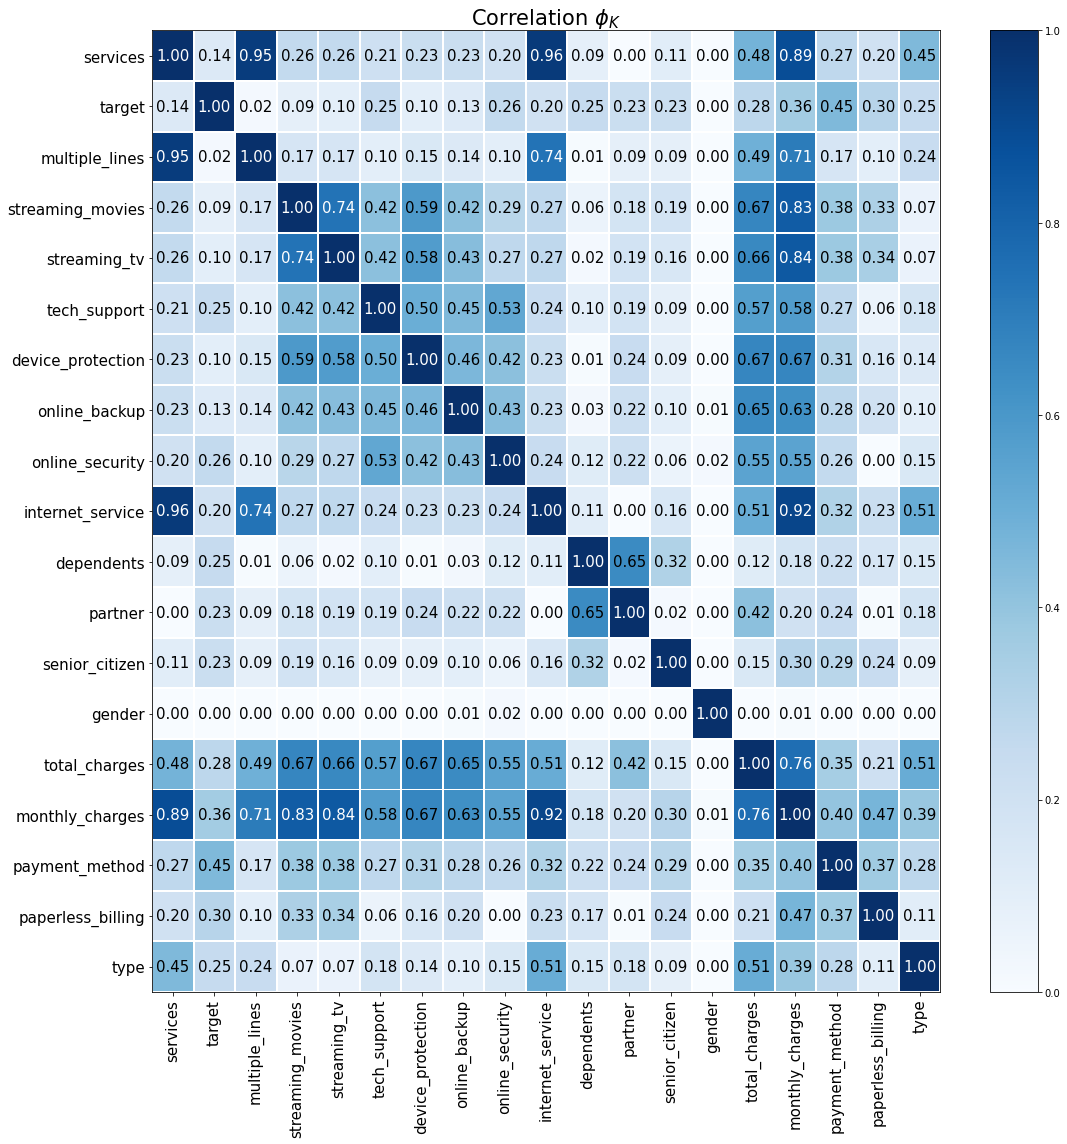

In [23]:
cols = ['type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges', 'gender',
        'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup',
        'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines', 'target',
        'services']
phik_table = round(df[cols].phik_matrix(interval_cols=['monthly_charges', 'total_charges']), 2)
plot_correlation_matrix(phik_table.values, 
                        x_labels=phik_table.columns, 
                        y_labels=phik_table.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"Correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(16, 16))

Сильнее всего с целевой переменной коррелируют признаки `payment_method` (0.45), `monthly_charges` (0.36),  `paperless_billing` (0.3) и `total_charges` (0.28). Признак `gender` совсем не коррелирует с целевой переменной и остальными признаками. Очень сильная корреляция наблюдается между `monthly_charges` и `internet_service` (0.92). Признак `services` уберем, он сформирован из `multiple_lines` и `internet_service` и сильно коррелирует с ними.

**Выводы:**
- ежемесячные расходы клиентов, которые ушли, в среднем больше (74.44 у.е.), чем расходы оставшихся (61.27 у.е.);
- общие расходы у оставшихся клиентов в среднем больше (2550 у.е.), чем у ушедших (1531 у.е.).;
- среди ушедших клиентов доля использовавших обе услуги больше (84.9%), чем среди оставшихся (62.8%);
- большинство ушедших клиентов платили за услуги помесячно, а большинство оставшихся платили сразу за год или два;
- ушедшие клиенты предпочитали безбумажные расчетный лист и электронный счет;
- пол клиента не влияет на отток;
- ушедшие клиенты использовали подключение преимущественно через оптоволоконный кабель;
- все ушедшие клиенты покинули компанию в период с 1 октября 2019 года по 1 января 2020 года;
- с июня 2019 года наблюдается отрицательная динамика поступления новых клиентов;
- самая сильная взаимосвязь с целевой переменной наблюдается с признаками `payment_method` (0.45), `monthly_charges` (0.36), `paperless_billing` (0.3) и `total_charges` (0.28);
- между целевой переменной и `gender` корреляция отсутствует, этот признак можно убрать.

## Обучение моделей

Подготовим данные для обучения моделей:

In [24]:
# разделение признаков на количественные и категориальные
num_features = ['monthly_charges', 'total_charges']
cat_features = ['type', 'paperless_billing', 'payment_method', 'senior_citizen', 'partner', 'dependents',
                'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support',
                'streaming_tv', 'streaming_movies', 'multiple_lines']

# разделение на обучающую и тестовую выборки для RandomForestClassifier и LGBMClassifier
df_rf = df[num_features + cat_features].copy()
df_rf[cat_features] = df_rf[cat_features].astype('category')
X_train, X_test, y_train, y_test = train_test_split(df_rf,
                                                    df['target'],
                                                    stratify=df['target'],
                                                    test_size=0.2,
                                                    random_state=SEED)

print(f'X_train: {X_train.shape}',
      f'X_test: {X_test.shape}',
      f'y_train: {y_train.shape}',
      f'y_test: {y_test.shape}',
      sep='\n')

# пайплан предобработки для RandomForestClassifier и нейронной сети
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), num_features),
                                               ('cat', OneHotEncoder(drop='first'), cat_features)])

X_train: (5634, 16)
X_test: (1409, 16)
y_train: (5634,)
y_test: (1409,)


In [25]:
# разделение на обучающую, тестовую и валидационную выборки для нейронной сети
X_train_net, X_test_val, y_train_net, y_test_val = train_test_split(df[num_features + cat_features],
                                                                    df['target'],
                                                                    stratify=df['target'],
                                                                    test_size=0.4,
                                                                    random_state=SEED)

X_test_net, X_val_net, y_test_net, y_val_net = train_test_split(X_test_val,
                                                                y_test_val,
                                                                stratify=y_test_val,
                                                                test_size=0.5,
                                                                random_state=SEED)


print(f'X_train_net: {X_train_net.shape}',
      f'X_val_net: {X_test_net.shape}',
      f'X_test_net: {X_test_net.shape}',
      f'y_train_net: {y_train_net.shape}',
      f'y_val_net: {y_test_net.shape}',
      f'y_test_net: {y_test_net.shape}',
      sep='\n')

# предобработка данных
X_train_prep = preprocessor.fit_transform(X_train_net)
X_val_prep = preprocessor.transform(X_val_net)
X_test_prep = preprocessor.transform(X_test_net)

# формирование загрузчиков данных
X_train_t =  torch.FloatTensor(X_train_prep)
y_train_t =  torch.FloatTensor(y_train_net)
X_val_t =  torch.FloatTensor(X_val_prep)
y_val_t =  torch.FloatTensor(y_val_net)
X_test_t =  torch.FloatTensor(X_test_prep)
y_test_t =  torch.FloatTensor(y_test_net)

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_dataloader = DataLoader(train_dataset, batch_size=129, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=129)
test_dataloader = DataLoader(test_dataset, batch_size=129)

X_train_net: (4225, 16)
X_val_net: (1409, 16)
X_test_net: (1409, 16)
y_train_net: (4225,)
y_val_net: (1409,)
y_test_net: (1409,)


### RandomForestClassifier

In [26]:
pipe = Pipeline([('preprocessor', preprocessor),
                 ('classifier', RandomForestClassifier(class_weight='balanced', random_state=SEED))])

param_grid = {'classifier__n_estimators': [120, 140, 160, 180],
              'classifier__max_depth': [5, 6, 7, 8, 9],
              'classifier__criterion': ['gini', 'entropy']}

grid_rf = GridSearchCV(pipe,
                       param_grid=param_grid,
                       cv=5,
                       scoring=['roc_auc', 'accuracy'],
                       refit='roc_auc',
                       verbose=3)
grid_rf.fit(X_train, y_train)

print(f'ROC-AUC: {round(grid_rf.best_score_, 4)}',
      f'Accuracy: {round(grid_rf.cv_results_["mean_test_accuracy"][grid_rf.best_index_], 4)}',
      'Наилучшие параметры:',
      f'criterion: {grid_rf.best_params_["classifier__criterion"]}',
      f'max_depth: {grid_rf.best_params_["classifier__max_depth"]}',
      f'n_estinators: {grid_rf.best_params_["classifier__n_estimators"]}',
      sep='\n')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END classifier__criterion=gini, classifier__max_depth=5, classifier__n_estimators=120; accuracy: (test=0.749) roc_auc: (test=0.855) total time=   0.4s
[CV 2/5] END classifier__criterion=gini, classifier__max_depth=5, classifier__n_estimators=120; accuracy: (test=0.741) roc_auc: (test=0.836) total time=   0.4s
[CV 3/5] END classifier__criterion=gini, classifier__max_depth=5, classifier__n_estimators=120; accuracy: (test=0.750) roc_auc: (test=0.846) total time=   0.4s
[CV 4/5] END classifier__criterion=gini, classifier__max_depth=5, classifier__n_estimators=120; accuracy: (test=0.748) roc_auc: (test=0.845) total time=   0.4s
[CV 5/5] END classifier__criterion=gini, classifier__max_depth=5, classifier__n_estimators=120; accuracy: (test=0.734) roc_auc: (test=0.821) total time=   0.4s
[CV 1/5] END classifier__criterion=gini, classifier__max_depth=5, classifier__n_estimators=140; accuracy: (test=0.752) roc_auc: (test=0.85

Модель случайного леса достигла метрики ROC-AUC 0.8428 с наилучшими параметрами: критерий entropy, глубина 8, количество оценщиков 120. Accuracy модели составила 0.7669.

### LGBMClassifier

In [27]:
model_lgbm = LGBMClassifier(random_state=SEED, metric='auc', class_weight='balanced')
param_grid = {'max_depth': [4, 5, 6, 7],
              'n_estimators': [40, 50, 60]}
grid_lgbm = GridSearchCV(model_lgbm,
                         param_grid=param_grid,
                         cv=5,
                         scoring=['roc_auc', 'accuracy'],
                         refit='roc_auc',
                         verbose=3,
                         n_jobs=-1)
grid_lgbm.fit(X_train, y_train)

print(f'ROC-AUC: {round(grid_lgbm.best_score_, 4)}',
      f'Accuracy: {round(grid_lgbm.cv_results_["mean_test_accuracy"][grid_lgbm.best_index_], 4)}',
      'Наилучшие параметры:',
      f'max_depth: {grid_lgbm.best_params_["max_depth"]}',
      f'n_estimators: {grid_lgbm.best_params_["n_estimators"]}',
      sep='\n')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_depth=4, n_estimators=40; accuracy: (test=0.755) roc_auc: (test=0.853) total time=  39.8s
[CV 2/5] END max_depth=4, n_estimators=40; accuracy: (test=0.755) roc_auc: (test=0.844) total time=  45.1s
[CV 3/5] END max_depth=4, n_estimators=40; accuracy: (test=0.751) roc_auc: (test=0.843) total time=   3.5s
[CV 4/5] END max_depth=4, n_estimators=40; accuracy: (test=0.752) roc_auc: (test=0.847) total time=   0.4s
[CV 5/5] END max_depth=4, n_estimators=40; accuracy: (test=0.739) roc_auc: (test=0.820) total time=   0.6s
[CV 1/5] END max_depth=4, n_estimators=50; accuracy: (test=0.760) roc_auc: (test=0.852) total time=   0.7s
[CV 2/5] END max_depth=4, n_estimators=50; accuracy: (test=0.753) roc_auc: (test=0.843) total time=   0.9s
[CV 3/5] END max_depth=4, n_estimators=50; accuracy: (test=0.755) roc_auc: (test=0.843) total time=   0.6s
[CV 4/5] END max_depth=4, n_estimators=50; accuracy: (test=0.751) roc_auc: (test=0.

Модель LGBMClassifier достигла метрики ROC-AUC 0.8414 с наилучшими параметрами: глубина 4, количество оценщиков 40. Accuracy модели составила 0.7504.

### Полносвязная нейронная сеть

In [28]:
class Net(nn.Module):
    
    def __init__(self,
                 n_in_neurons,
                 n_hidden_neurons_1,
                 n_hidden_neurons_2,
                 n_out_neurons):
        super().__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn = nn.BatchNorm1d(n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.Sigmoid()

        
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.normal_(self.fc1.bias, mean=0, std=0.5)
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.normal_(self.fc2.bias, mean=0, std=0.5)
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='relu')
        nn.init.normal_(self.fc3.bias, mean=0, std=0.5)

        
    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.bn(self.fc2(x)))
        x = self.act3(self.fc3(x))

        return x

In [29]:
torch.manual_seed(SEED)
np.random.seed(SEED)

best_epoch = None
best_roc_auc = 0
roc_auc_train = 0
accuracy = 0


net = Net(X_train_t.shape[1], X_train_t.shape[1] // 2, X_train_t.shape[1] // 4, 1).to(DEVICE)
loss = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', threshold=0.001)

loss_tr = []
loss_val = []
roc_auc_tr = []
roc_auc_val = []

for epoch in notebook.tqdm(range(1, 76)):
    if epoch % 10 == 0 or epoch == 75:
        print('epoch', epoch)
    net.train()
    avg_loss = 0
    avg_loss_val = 0
    avg_roc_auc = 0
    avg_roc_auc_val = 0
    avg_accuracy = 0
    
    for X_batch, Y_batch in train_dataloader:
        X_batch = X_batch.to(DEVICE)
        Y_batch = Y_batch.to(DEVICE)
        optimizer.zero_grad()
        outp = net(X_batch).flatten(start_dim=-2)
        loss_value = loss(outp, Y_batch)
        loss_value.backward()
        optimizer.step()
        avg_loss += loss_value / len(train_dataloader)
        avg_roc_auc += roc_auc_score(Y_batch.cpu().numpy(),
                                     outp.cpu().detach().numpy()) / len(train_dataloader)
    
    scheduler.step(avg_loss)
    loss_tr.append(avg_loss.cpu().detach())
    roc_auc_tr.append(avg_roc_auc)
    
    if epoch % 10 == 0 or epoch == 75:
        print('loss: %f' % avg_loss)
        print('roc_auc: %f' % avg_roc_auc)
            
    net.eval() 
    with torch.no_grad():
        for X_batch, Y_batch in val_dataloader:
            X_batch = X_batch.to(DEVICE)
            Y_batch = Y_batch.to(DEVICE)
            preds_val = net(X_batch).flatten(start_dim=-2)
            loss_value = loss(preds_val, Y_batch)
            avg_loss_val += loss_value / len(val_dataloader)
            avg_roc_auc_val += roc_auc_score(Y_batch.cpu().numpy(),
                                             preds_val.cpu().detach().numpy()) / len(val_dataloader)
            avg_accuracy += accuracy_score(Y_batch.cpu().numpy(),
                                           np.round(preds_val.cpu().detach().numpy())) / len(val_dataloader)

        loss_val.append(avg_loss_val.cpu().detach())
        roc_auc_val.append(avg_roc_auc_val)
            
        if epoch % 10 == 0 or epoch == 75:
            print('loss_val: %f' % avg_loss_val)
            print('roc_auc_val: %f' % avg_roc_auc_val)
        if avg_roc_auc_val > best_roc_auc:
            best_roc_auc = avg_roc_auc_val
            best_epoch = epoch
            roc_auc_train = avg_roc_auc
            accuracy = avg_accuracy

    torch.cuda.empty_cache()

  0%|          | 0/75 [00:00<?, ?it/s]

epoch 10
loss: 0.451421
roc_auc: 0.814869
loss_val: 0.457242
roc_auc_val: 0.810682
epoch 20
loss: 0.426048
roc_auc: 0.838729
loss_val: 0.438493
roc_auc_val: 0.828448
epoch 30
loss: 0.417593
roc_auc: 0.845739
loss_val: 0.433597
roc_auc_val: 0.832416
epoch 40
loss: 0.414428
roc_auc: 0.848358
loss_val: 0.431523
roc_auc_val: 0.836078
epoch 50
loss: 0.409669
roc_auc: 0.852061
loss_val: 0.429573
roc_auc_val: 0.838375
epoch 60
loss: 0.409842
roc_auc: 0.852422
loss_val: 0.428995
roc_auc_val: 0.838995
epoch 70
loss: 0.405328
roc_auc: 0.856853
loss_val: 0.428205
roc_auc_val: 0.839152
epoch 75
loss: 0.403044
roc_auc: 0.855579
loss_val: 0.427068
roc_auc_val: 0.840648


Посмотрим как обучалась сеть:

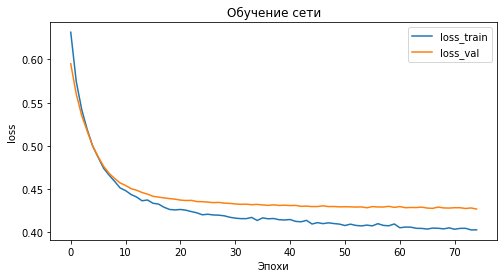

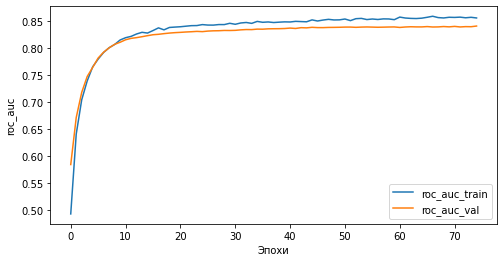

In [30]:
plt.figure(figsize=(8, 4))
plt.plot(loss_tr, label="loss_train")
plt.plot(loss_val, label="loss_val")
plt.legend()
plt.title('Обучение сети')
plt.xlabel('Эпохи')
plt.ylabel('loss')

plt.figure(figsize=(8, 4))
plt.plot(roc_auc_tr, label="roc_auc_train")
plt.plot(roc_auc_val, label="roc_auc_val")
plt.legend()
plt.xlabel('Эпохи')
plt.ylabel('roc_auc')
plt.show()

In [31]:
print(f'epoch: {best_epoch}', 
      f'RMSE train: {round(roc_auc_train, 4)}',
      f'RMSE val: {round(best_roc_auc, 4)}',
      f'Accuracy val: {round(accuracy, 4)}',
      sep='\n')

epoch: 75
RMSE train: 0.8556
RMSE val: 0.8406
Accuracy val: 0.7878


Нейронная сеть с двумя скрытыми слоями, гиперболическим тангенсом после первого линейного слоя, нормализацией и функцией активации ReLU после второго линейного слоя достигла метрики RMSE 0.8406 за 75 эпох обучения. Accuracy модели составила 0.7878.

Объединим полученные результаты в таблицу:

In [32]:
result = pd.DataFrame({'ROC-AUC': [round(grid_rf.best_score_, 4),
                                   round(grid_lgbm.best_score_, 4),
                                   round(best_roc_auc, 4)],
                       'Accuracy':[round(grid_rf.cv_results_["mean_test_accuracy"][grid_rf.best_index_], 4),
                                   round(grid_lgbm.cv_results_["mean_test_accuracy"][grid_lgbm.best_index_], 4),
                                   round(accuracy, 4)]},
                      index=['RandomForestClassifier', 'LGBMClassifier', 'Net'])
result

,ROC-AUC,Accuracy
RandomForestClassifier,0.8428,0.7669
LGBMClassifier,0.8414,0.7504
Net,0.8406,0.7878


**Выводы:**
- бустинг и случайный лес показали лучшие результаты по метрике ROC-AUC, чем нейронная сеть. Скорее всего это произошло из-за преобладающих категориальных признаков. Accuracy нейронной сети (0.7878) выше, чем у бустинга (0.7504) и случайного леса (0.7669), из-за несбалансированных классов это значение не вполне отражает качество модели;
- наибольшее значение метрики ROC-AUC получилось с моделью RandomForestClassifier (0.8428) с параметрами критерий entropy, глубина 8, количество оценщиков 120. Accuracy модели составила 0.7669.

## Тестирование модели

Протестируем наилучшую модель RandomForestClassifier:

In [33]:
preds = grid_rf.predict_proba(X_test)[:, 1]
print(f'ROC-AUC test: {round(roc_auc_score(y_test, preds), 4)}')

ROC-AUC test: 0.85


Выведем на график матрицу ошибок и построим ROC-кривую:

0.0    1035
1.0     374
Name: target, dtype: int64


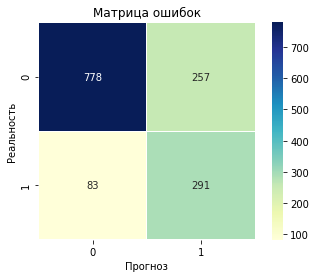

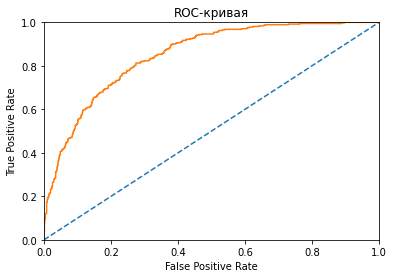

In [34]:
print(y_test.value_counts())

sns.heatmap(confusion_matrix(y_test, grid_rf.predict(X_test)),
            cmap='YlGnBu',
            square=True, 
            linewidths=0.1,
            annot=True,
            fmt='d').set_title('Матрица ошибок')
plt.ylabel('Реальность')
plt.xlabel('Прогноз')

fpr, tpr, thresholds = roc_curve(y_test, preds)
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Модель хорошо предсказывает ушедших клиентов (ошибка примерно в 22% случаев) и немного хуже оставшихся (ошибка примерно в 24.8% случаев). Метрика ROC-AUC на тестовой выборке составила 0.85.

Посмотрик какие признаки модель считает наиболее важными:

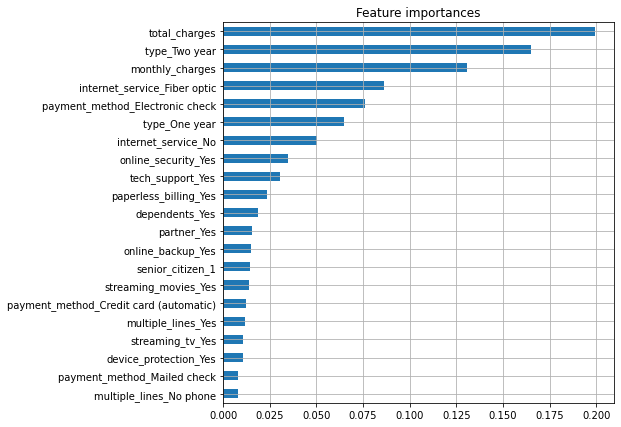

In [35]:
cols = num_features + grid_rf.best_estimator_ \
                             .named_steps['preprocessor'] \
                             .transformers_[1][1] \
                             .get_feature_names(cat_features) \
                             .tolist()
feature_importances = grid_rf.best_estimator_['classifier'].feature_importances_

pd.DataFrame(data=feature_importances,
             index=cols,
             columns=['feature_importances']) \
  .sort_values('feature_importances') \
  .plot(kind='barh',
        title='Feature importances',
        legend=False,
        grid=True,
        figsize=(7, 7))
plt.show()

Самые важные признаки это общие расходы и тип оплаты (раз в один-два года или помесячно). Также заметное влияние оказывают тип платежа, тип подключения и расходы за месяц. Рассмотрим подробнее общие расходы и тип оплаты:

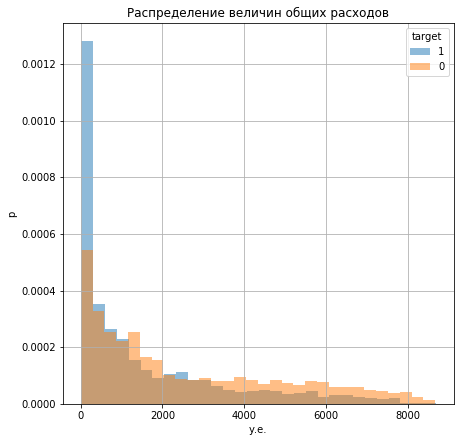

,loyal_clients_total,ex_clients_total
count,5174.00,1869.00
mean,2549.91,1531.80
std,2329.95,1890.82
min,0.00,18.85
25%,572.90,134.50
50%,1679.52,703.55
75%,4262.85,2331.30
max,8672.45,8684.80


In [36]:
plt.figure(figsize=(7, 7))
plt.xlabel('у.е.')
plt.ylabel('p')
df.loc[df['target'] == 1, 'total_charges'].hist(bins=30, density=True, alpha=0.5)
df.loc[df['target'] == 0, 'total_charges'].hist(bins=30, density=True, alpha=0.5)
plt.legend(['1', '0'], title='target')
plt.title('Распределение величин общих расходов')
plt.show()

display(stat[['loyal_clients_total', 'ex_clients_total']])

Общие расходы оставшихся клиентов (2550 у.е.) превышают расходы ушедших (1531 у.е.). Максимальные значения общих расходов между группами практически совпадает, но по первому, второму и третьему квартилям видно значительное превышение суммы общих расходов оставшихся клиентов над ушедшими.

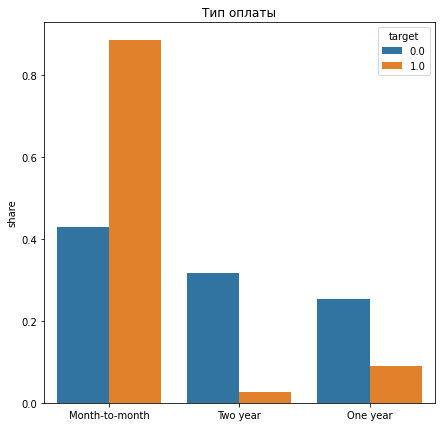

In [37]:
plt.figure(figsize=(7, 7))
tmp = df.groupby('target')['type'].value_counts(normalize=True).rename('share').reset_index()
sns.barplot(data=tmp, y='share', x='type', hue='target')
plt.title('Тип оплаты')
plt.xlabel('')
plt.show()

На графике видно, что около 90% ушедших клиентов платили помесячно. Около 42% оставшихся клиентов платили помесячно, а остальные 58% платили на год-два вперед. 

## Выводы

- наилучшей моделью по метрике ROC-AUC стала модель случайного леса с параметрами критерий entropy, глубина 8, количество оценщиков 120. Метрика ROC-AUC на тестовой выборке составила 0.85;
- самые важные признаки - общие расходы, тип оплаты (раз в один-два года или помесячно), тип платежа, тип подключения и расходы за месяц;
- так как основной отток клиентов произошел в ограниченный период времени - 1 октября 2019 года по 1 января 2020 года, следует проанализировать существовавшую тогда ценовую политику компании и ее конкурентов, чтобы понять причину оттока;
- также, с целью предотвращения дальнейшего оттока и привлечения новых клиентов следует разработать систему мотивации пользователей на заключение контрактов с оплатой на год-два вперед.